# python DB connect

mysql 데이터 베이스에 테이블을 만들고 python 코드를 이용해서 데이터를 써보겠습니다. 
이를 통해서 코드를 이용해서 데이터를 다루는 법을 익혀보겠습니다.

## DB 테이블 만들기

먼저 mysql workbench를 열어주고, 타이타닉 데이터 셋을 저장하기 위한 테이블을 만들어주겠습니다. Name 필드의 데이터 타입에 신경써주세요.

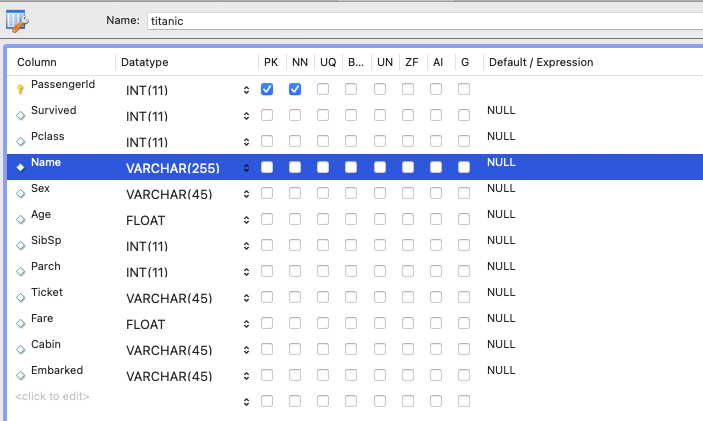

## python 코드로 mysql 접속하기

python 코드에서 mysql을 접속하기 위해서는 pymysql 라이브러리를 이용해야합니다.  
설치한 뒤에 사용해보겠습니다.

In [1]:
!pip install pymysql


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pymysql 

conn = pymysql.connect(
    host="127.0.0.1",
    user="root",
    password="1234",
    database="multicampus",
)

## Read Query

먼저 타이타닉 테이블에 모든 데이터를 읽어보겠습니다.  
SQL 쿼리를 날리고 싶을 때는 with문을 사용해서 connection의 cursor를 만들어서 사용합니다.

In [43]:
select_sql = "SELECT * FROM titanic"
with conn.cursor() as cursor:
    cursor.execute(select_sql)
    result = cursor.fetchall()

In [44]:
print("total records", len(result))
for row in result:
    print(row)

total records 10
(1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, None, 'S')
(2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833, 'C85', 'C')
(3, 1, 3, 'Heikkinen, Miss. Laina', 'female', 26.0, 0, 0, 'STON/O2. 3101282', 7.925, None, 'S')
(4, 1, 1, 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'female', 35.0, 1, 0, '113803', 53.1, 'C123', 'S')
(5, 0, 3, 'Allen, Mr. William Henry', 'male', 35.0, 0, 0, '373450', 8.05, None, 'S')
(6, 0, 3, 'Moran, Mr. James', 'male', None, 0, 0, '330877', 8.4583, None, 'Q')
(7, 0, 1, 'McCarthy, Mr. Timothy J', 'male', 54.0, 0, 0, '17463', 51.8625, 'E46', 'S')
(8, 0, 3, 'Palsson, Master. Gosta Leonard', 'male', 2.0, 3, 1, '349909', 21.075, None, 'S')
(9, 1, 3, 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)', 'female', 27.0, 0, 2, '347742', 11.1333, None, 'S')
(10, 1, 2, 'Nasser, Mrs. Nicholas (Adele Achem)', 'female', 14.0, 1, 0, '237736', 30.0708, None, 'C')


## Write Query

현재는 타이타닉 테이블이 텅 비어있습니다.  
이번에는 csv 파일을 읽어와서 한줄 한줄 타이타닉 테이블에 써보겠습니다.

In [45]:
write_sql = "INSERT INTO titanic VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

In [50]:
import csv

with open("./data/titanic_train.csv") as fr:
    reader = csv.reader(fr)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        if i > 10:
            break
        row = [x if x else None for x in row] 
        with conn.cursor() as cursor:
            result = cursor.execute(write_sql, row)
            conn.commit()
        print("write: ", result)

write:  1
write:  1
write:  1
write:  1
write:  1
write:  1
write:  1
write:  1
write:  1
write:  1


## Delete Query

기존 타이타닉 테이블 데이터를 지우는 쿼리도 날려보겠습니다.

In [2]:
delete_sql = "delete from titanic"
with conn.cursor() as cursor:
    result = cursor.execute(delete_sql)
    conn.commit()
    print("deleted:", result)

deleted: 891


## Bulk Write Query(심화)

디비에 데이터를 한줄 한줄 쓰는 작업은 굉장히 비효율적입니다.  
여러 줄을 한꺼번에 입력하는게 훨씬 성능이 뛰어납니다.  
한번 pymysql의 execute_many 기능을 이용해서 여러 데이터를 한꺼번에 입력해보겠습니다.

In [52]:
write_sql = "INSERT INTO titanic VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

In [53]:
def _execute_insert(buffer):
    with conn.cursor() as cursor:
        result = cursor.executemany(write_sql, buffer)
        conn.commit()
        print("write:", result)

In [54]:
def bulk_write(data_file_path, batchsize=100):
    with open(data_file_path) as fr:
        reader = csv.reader(fr)
        buffer = []
        for i, row in enumerate(reader):
            if i == 0:
                continue
            row = [x if x else None for x in row]
            buffer.append(row)
            if len(buffer) == batchsize:
                _execute_insert(buffer)
                buffer = []
        if buffer:
            _execute_insert(buffer)

In [55]:
bulk_write("./data/titanic_train.csv")

write: 100
write: 100
write: 100
write: 100
write: 100
write: 100
write: 100
write: 100
write: 91


In [26]:
conn.close()

## 타이타닉 생존자 데이터 읽기

데이터 베이스에 데이터를 채워넣었으니, 이제 SQL 쿼리를 작성해서 원하는 형태로 데이터를 읽어보겠습니다.  
한번 생존자 중에 3등칸에 탔으며, 나이가 10살 이하인 승객들의 이름만 읽어보겠습니다.

In [69]:
read_sql = """
SELECT 
    Name 
FROM
    titanic 
WHERE 
    Survived=1 
    AND Pclass=3
    AND Age <=10
"""

In [6]:
def read_data(sql):
    with conn.cursor() as cursor:
        cursor.execute(sql)
        result = cursor.fetchall()
    return result

In [7]:
read_data(read_sql)

NameError: name 'read_sql' is not defined

### 연습문제

1. 운임을 50달러 이하로 지불한 승객들 가운데 승선지가 C 혹은 Q 인 사람들의 이름을 읽어오세요. (WHERE)
2. 부모, 자식이 한명이라도 탑승한 승객들 가운데 사망한 사람의 이름을 읽어오세요. (WHERE)
3. 생존자들 가운데 나이가 많은 상위 10명의 이름을 읽어오세요. (ORDER BY, LIMIT)
4. 생존자들 가운데 나이가 10번째로 많은 사람부터 20번째로 많은 사람까지 읽어오세요. (ORDER BY, LIMIT, OFFSET)
5. 1등석, 2등석, 3등석 승객들의 총 운임, 평균 운임을 각각 구하세요. (GROUP BY, SUM, AVG)
6. 좌석 등급, 성별로 그룹을 지어 평균 연령을 집계해보세요. (GROUP BY, AVG)
7. 승선지, 좌석 등급으로 그룹을 지어 몇명의 승객이 탔는지 집계해보세요. (GROUP BY, COUNT)

In [20]:
# 1번
sql = """
SELECT
    Name
FROM
    titanic
WHERE
    Fare <= 50
    AND (Embarked="C" OR EMBARKED="Q")
"""
result = read_data(sql)
print(len(result))
print(result[:5])

182
(('Moran, Mr. James',), ('Nasser, Mrs. Nicholas (Adele Achem)',), ('Rice, Master. Eugene',), ('Masselmani, Mrs. Fatima',), ('McGowan, Miss. Anna "Annie"',))


In [26]:
# 2번
sql = """
SELECT
    Name
FROM
    titanic
WHERE
    Parch > 0
    AND Survived=0
"""
result = read_data(sql)
print(len(result))
print(result[:10])

104
(('Palsson, Master. Gosta Leonard',), ('Andersson, Mr. Anders Johan',), ('Rice, Master. Eugene',), ('Palsson, Miss. Torborg Danira',), ('Fortune, Mr. Charles Alexander',), ('Panula, Master. Juha Niilo',), ('Ostby, Mr. Engelhart Cornelius',), ('Goodwin, Master. William Frederick',), ('Skoog, Master. Harald',), ('Goodwin, Miss. Lillian Amy',))


In [25]:
# 3번
sql = """
SELECT
    Name,
    Age
FROM
    titanic
ORDER BY
    Age DESC
LIMIT
    10
"""
result = read_data(sql)
print(len(result))
print(result)

10
(('Barkworth, Mr. Algernon Henry Wilson', 80.0), ('Svensson, Mr. Johan', 74.0), ('Goldschmidt, Mr. George B', 71.0), ('Artagaveytia, Mr. Ramon', 71.0), ('Connors, Mr. Patrick', 70.5), ('Mitchell, Mr. Henry Michael', 70.0), ('Crosby, Capt. Edward Gifford', 70.0), ('Wheadon, Mr. Edward H', 66.0), ('Duane, Mr. Frank', 65.0), ('Ostby, Mr. Engelhart Cornelius', 65.0))


In [24]:
# 4번
sql = """
SELECT
    Name,
    Age
FROM
    titanic
ORDER BY
    Age DESC
LIMIT
    10
OFFSET
    10
"""
result = read_data(sql)
print(len(result))
print(result)

10
(('Millet, Mr. Francis Davis', 65.0), ('Nicholson, Mr. Arthur Ernest', 64.0), ('Fortune, Mr. Mark', 64.0), ('Andrews, Miss. Kornelia Theodosia', 63.0), ('Turkula, Mrs. (Hedwig)', 63.0), ('Wright, Mr. George', 62.0), ('Harris, Mr. George', 62.0), ('Stone, Mrs. George Nelson (Martha Evelyn)', 62.0), ('Stead, Mr. William Thomas', 62.0), ('Nysveen, Mr. Johan Hansen', 61.0))


In [13]:
# 5번
sql = """
SELECT
    Pclass,
    SUM(Fare),
    AVG(Fare)
FROM
    titanic
GROUP BY
    Pclass
"""
read_data(sql)

((1, 18177.412506103516, 84.15468752825701),
 (2, 3801.8417053222656, 20.66218318109927),
 (3, 6714.695153236389, 13.675550210257411))

In [27]:
# 6번
sql = """
SELECT
    Pclass,
    Sex,
    AVG(Age)
FROM
    titanic
GROUP BY
    Pclass,
    Sex
"""
read_data(sql)

((1, 'female', 34.61176470588235),
 (1, 'male', 41.281386138779105),
 (2, 'female', 28.722972972972972),
 (2, 'male', 30.74070707053849),
 (3, 'female', 21.75),
 (3, 'male', 26.507588932754494))

In [28]:
# 7번
sql = """
SELECT
    Pclass,
    Embarked,
    count(*)
FROM
    titanic
GROUP BY
    Pclass,
    Embarked
"""
read_data(sql)

((1, None, 2),
 (1, 'C', 85),
 (1, 'Q', 2),
 (1, 'S', 127),
 (2, 'C', 17),
 (2, 'Q', 3),
 (2, 'S', 164),
 (3, 'C', 66),
 (3, 'Q', 72),
 (3, 'S', 353))